In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense
import xgboost as xgb  # xgboost 라이브러리 import
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings('ignore')

### Feature selection
#### Feature selection의 목적
- 통계기반 변수 선택 VS 모형기반 변수 선택

- 영향력 있는 feature만 추출하기 위함

- 변수들 간에 상관관계가 있는 경우 성능 영향 고려

- 덜 중요한 feature는 예측모델의 불확실성을 높임

#### 1. SelectKBest

- scikit-learn에서 제공하는 라이브러리

- 각 특성(feature)과 종속 변수(target) 간의 통계적 유의성을 기반으로 상위 K개의 최적 특성을 선택함

#### 2. SelectFromModel

- 모델 훈련이 끝난 후 사용자가 지정한 임계값을 기반으로 특성을 선택함

In [3]:
path1='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0731.csv'
df_raw=pd.read_csv(path1)
df_raw.head(2)

,sido,create_date,sido_cd,weekend_yn,grid_x,grid_y,sat_x,sat_y,min_ta,max_ta,...,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,instDate,updtDate
0,경기도,2014-05-01,31,0,60,120,NaN,NaN,9.6,24.2,...,15,21,24,22,14,21,17,0,2024-07-31,2024-07-31
1,충청북도,2014-05-01,33,0,69,107,NaN,NaN,10.5,23.7,...,15,21,23,22,15,22,18,0,2024-07-31,2024-07-31


In [4]:
# 'date' 컬럼을 datetime 형식으로 변환
df_raw['create_date'] = pd.to_datetime(df_raw['create_date'])
# year, month, day 컬럼 생성
df_raw['year'] = df_raw['create_date'].dt.year
df_raw['month'] = df_raw['create_date'].dt.month
df_raw['day'] = df_raw['create_date'].dt.day

# 클래스 정보로 담아내기
df_raw['patientsCD'] = df_raw['patientsCnt'].apply(lambda x: 0 if x == 0 else 1)

# 결측치 채우기
df_raw = df_raw.fillna(0)

In [5]:
lst=['create_date','weekend_yn', 'year', 'month', 'day', 'min_ta', 'max_ta', 'mean_ta', 'gap_ta', 'min_tafeel', 'max_tafeel', 'mean_tafeel', 'gap_tafeel', 'min_hm', 'max_hm', 'mean_hm', 'gap_hm', 'min_wbtemp', 'max_wbtemp', 'mean_wbtemp',
    'gap_wbtemp', 'min_ws', 'max_ws', 'mean_ws', 'tropical_3days', 'heatwave_temp', 'heatalert_temp', 'ta_min_3days', 'ta_max_3days', 'gap_ta_minmax', 'popular_man', 'popular_woman', 'agriculture_man',
    'agriculture_woman', 'ta_min_am', 'ta_max_am', 'ta_mean_am', 'ta_min_pm', 'ta_max_pm', 'ta_mean_pm', 'ta_min_six_am1', 'ta_max_six_am1', 'ta_mean_six_am1', 'ta_min_six_am2', 'ta_max_six_am2', 'ta_mean_six_am2',
    'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_min_six_pm2', 'ta_max_six_pm2', 'ta_mean_six_pm2', 'patientsCnt', 'patientsCD']
print('raw의 변수 개수: ', len(lst), '개')
df=df_raw[lst]

raw의 변수 개수:  54 개


In [6]:
df.head(2)

,create_date,weekend_yn,year,month,day,min_ta,max_ta,mean_ta,gap_ta,min_tafeel,...,ta_max_six_am2,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,patientsCD
0,2014-05-01,0,2014,5,1,9.6,24.2,16.6,14.6,12.35,...,21,15,21,24,22,14,21,17,0,0
1,2014-05-01,0,2014,5,1,10.5,23.7,17.1,13.2,12.78,...,21,15,21,23,22,15,22,18,0,0


#### 1. SelectKBest

#### 1-1. patientsCnt 기준

- target과 변수 사이의 상관관계 분석

- 가장 상관관계가 높은 K개의 변수 선정

In [8]:
# 변수선택(feature selection) 하기
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
# Feature와 Target 분리
# patientsCnt 기준으로 작업
X = df.drop(columns=['create_date', 'patientsCnt', 'patientsCD'])
y = df['patientsCnt']

In [10]:
# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# SelectKBest를 사용한 변수 선택
# 총 변수는 45개
k = 15  # 선택할 변수의 수(랜덤선택)
selector = SelectKBest(score_func=f_regression, k=k)
X_new = selector.fit_transform(X_train, y_train)

# 선택된 변수의 인덱스
selected_indices = selector.get_support(indices=True)

# 선택된 변수의 이름
selected_features = X.columns[selected_indices]
print("Selected Features:", selected_features)

Selected Features: Index(['max_ta', 'mean_ta', 'max_tafeel', 'heatwave_temp', 'heatalert_temp',
       'ta_max_am', 'ta_max_pm', 'ta_mean_pm', 'ta_max_six_am2',
       'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1',
       'ta_mean_six_pm1', 'ta_max_six_pm2', 'ta_mean_six_pm2'],
      dtype='object')


In [12]:
df.head(3)

,create_date,weekend_yn,year,month,day,min_ta,max_ta,mean_ta,gap_ta,min_tafeel,max_tafeel,mean_tafeel,gap_tafeel,min_hm,max_hm,mean_hm,gap_hm,min_wbtemp,max_wbtemp,mean_wbtemp,gap_wbtemp,min_ws,max_ws,mean_ws,tropical_3days,heatwave_temp,heatalert_temp,ta_min_3days,ta_max_3days,gap_ta_minmax,popular_man,popular_woman,agriculture_man,agriculture_woman,ta_min_am,ta_max_am,ta_mean_am,ta_min_pm,ta_max_pm,ta_mean_pm,ta_min_six_am1,ta_max_six_am1,ta_mean_six_am1,ta_min_six_am2,ta_max_six_am2,ta_mean_six_am2,ta_min_six_pm1,ta_max_six_pm1,ta_mean_six_pm1,ta_min_six_pm2,ta_max_six_pm2,ta_mean_six_pm2,patientsCnt,patientsCD
0,2014-05-01,0,2014,5,1,9.6,24.2,16.6,14.6,12.35,22.04,17.0,9.7,30.0,98.0,61.1,5.4,8.8,14.2,11.6,5.4,0.3,3.5,1.7,0,0,0,9.6,24.2,14.6,6219813,6138017,186278,188594,9,21,13,14,24,20,9.0,13.0,10.0,9,21,15,21,24,22,14,21,17,0,0
1,2014-05-01,0,2014,5,1,10.5,23.7,17.1,13.2,12.78,22.16,17.5,9.4,33.0,91.0,60.0,5.6,9.3,14.9,12.0,5.6,0.0,3.7,1.6,0,0,0,10.5,23.7,13.2,796141,782792,92687,95065,10,21,14,15,23,20,10.0,14.0,12.0,10,21,15,21,23,22,15,22,18,0,0
2,2014-05-01,0,2014,5,1,13.5,25.3,19.0,11.8,16.29,23.66,19.6,7.4,27.0,97.0,64.7,3.4,12.7,16.1,14.2,3.4,0.1,3.7,1.9,0,0,0,13.5,25.3,11.8,1241119,1252145,25045,24142,13,21,16,18,25,22,13.0,14.0,14.0,14,21,17,21,25,23,18,24,20,0,0


#### 1-2. patientsCD 기준

In [15]:
# Feature와 Target 분리
# patientsCnt 기준으로 작업
X = df.drop(columns=['create_date', 'patientsCnt', 'patientsCD'])
y = df['patientsCD']

In [16]:
# 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# SelectKBest를 사용한 변수 선택
# 총 변수는 45개
k = 15  # 선택할 변수의 수(랜덤선택)
selector = SelectKBest(score_func=f_regression, k=k)
X_new = selector.fit_transform(X_train, y_train)

# 선택된 변수의 인덱스
selected_indices = selector.get_support(indices=True)

# 선택된 변수의 이름
selected_features = X.columns[selected_indices]
print("Selected Features:", selected_features)

Selected Features: Index(['max_ta', 'mean_ta', 'max_tafeel', 'mean_tafeel', 'ta_max_am',
       'ta_mean_am', 'ta_max_pm', 'ta_mean_pm', 'ta_max_six_am2',
       'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1',
       'ta_mean_six_pm1', 'ta_max_six_pm2', 'ta_mean_six_pm2'],
      dtype='object')


In [13]:
# 사용할 특징 변수 정의
features = ['max_ta', 'mean_ta', 'max_tafeel', 'heatwave_temp', 'heatalert_temp', 'ta_max_am', 'ta_max_pm', 'ta_mean_pm', 'ta_max_six_am2',
            'ta_mean_six_am2', 'ta_min_six_pm1', 'ta_max_six_pm1', 'ta_mean_six_pm1', 'ta_max_six_pm2', 'ta_mean_six_pm2']
target = 'patientsCnt'

In [16]:
# Feature와 Target 분리
X=[]
y=[]
X = df[features]
y = df[target]
dates = df['create_date']

In [17]:
# 데이터 스케일링
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# 시퀀스 생성 함수
def create_sequences(data, target, dates, sequence_length):
    Xs, ys, date_sequences = [], [], []
    for i in range(len(data) - sequence_length):
        Xs.append(data[i:(i + sequence_length)])
        ys.append(target[i + sequence_length])
        date_sequences.append(dates[i + sequence_length])
    return np.array(Xs), np.array(ys), np.array(date_sequences)

In [18]:
sequence_length = 10
X_sequences, y_sequences, date_sequences = create_sequences(X_scaled, y.values, dates.values, sequence_length)

# 학습 데이터와 테스트 데이터로 분할
X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X_sequences, y_sequences, date_sequences, test_size=0.2, random_state=42)

# RNN 모델 생성 및 학습
rnn_model = Sequential()
rnn_model.add(SimpleRNN(50, activation='relu', input_shape=(sequence_length, X_train.shape[2])))
rnn_model.add(Dense(1))
rnn_model.compile(optimizer='adam', loss='mse')
rnn_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# LSTM 모델 생성 및 학습
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(sequence_length, X_train.shape[2])))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))

# XGBoost 모델 생성 및 학습
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
xgb_model = XGBRegressor()
xgb_model.fit(X_train_flat, y_train)


Epoch 1/50
650/650 [==============================] - 2s 2ms/step - loss: 4.5334 - val_loss: 3.5201
Epoch 2/50
650/650 [==============================] - 1s 1ms/step - loss: 4.2041 - val_loss: 3.5240
Epoch 3/50
650/650 [==============================] - 1s 1ms/step - loss: 4.1095 - val_loss: 3.2603
Epoch 4/50
650/650 [==============================] - 1s 1ms/step - loss: 3.9172 - val_loss: 3.0371
Epoch 5/50
650/650 [==============================] - 1s 1ms/step - loss: 3.5849 - val_loss: 3.4371
Epoch 6/50
650/650 [==============================] - 1s 1ms/step - loss: 3.4265 - val_loss: 2.9446
Epoch 7/50
650/650 [==============================] - 1s 1ms/step - loss: 3.4726 - val_loss: 2.8233
Epoch 8/50
650/650 [==============================] - 1s 1ms/step - loss: 3.2130 - val_loss: 2.7920
Epoch 9/50
650/650 [==============================] - 1s 1ms/step - loss: 3.1637 - val_loss: 2.9368
Epoch 10/50
650/650 [==============================] - 1s 1ms/step - loss: 3.1800 - val_loss: 2.6527

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [19]:
# 예측 및 평가
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{model_name} model performance:')
    print(f'MAE: {mae:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'R2: {r2:.4f}')
    return y_pred

# RNN 평가
y_pred_rnn = evaluate_model(rnn_model, X_test, y_test, 'RNN')
# LSTM 평가
y_pred_lstm = evaluate_model(lstm_model, X_test, y_test, 'LSTM')
# XGBoost 평가
y_pred_xgb = evaluate_model(xgb_model, X_test_flat, y_test, 'XGBoost')

163/163 [==============================] - 0s 806us/step
RNN model performance:
MAE: 0.7317
MSE: 2.5582
R2: 0.4887
163/163 [==============================] - 0s 1ms/step
LSTM model performance:
MAE: 0.6932
MSE: 2.5040
R2: 0.4995
XGBoost model performance:
MAE: 0.6274
MSE: 2.0494
R2: 0.5904


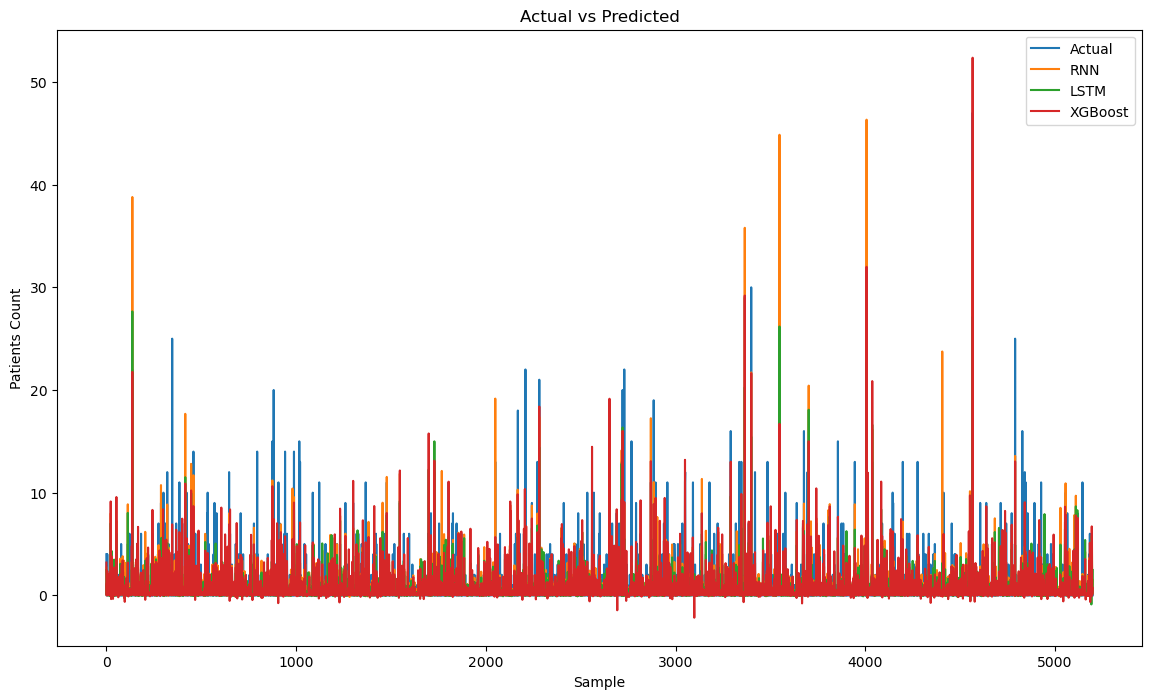

In [21]:
# 결과 시각화
plt.figure(figsize=(14, 8))
plt.plot(y_test, label='Actual')
plt.plot(y_pred_rnn, label='RNN')
plt.plot(y_pred_lstm, label='LSTM')
plt.plot(y_pred_xgb, label='XGBoost')
plt.legend()
plt.title('Actual vs Predicted')
plt.xlabel('Sample')
plt.ylabel('Patients Count')
plt.show()

In [25]:
# 각 배열을 1차원으로 변환
dates_test_1d = dates_test.flatten()
y_test_1d = y_test.flatten()
y_pred_rnn_1d = y_pred_rnn.flatten()
y_pred_lstm_1d = y_pred_lstm.flatten()
y_pred_xgb_1d = y_pred_xgb.flatten()

# 결과를 데이터프레임으로 결합
results_df = pd.DataFrame({
    'Date': dates_test_1d,
    'Actual': y_test_1d,
    'RNN': y_pred_rnn_1d,
    'LSTM': y_pred_lstm_1d,
    'XGBoost': y_pred_xgb_1d
})

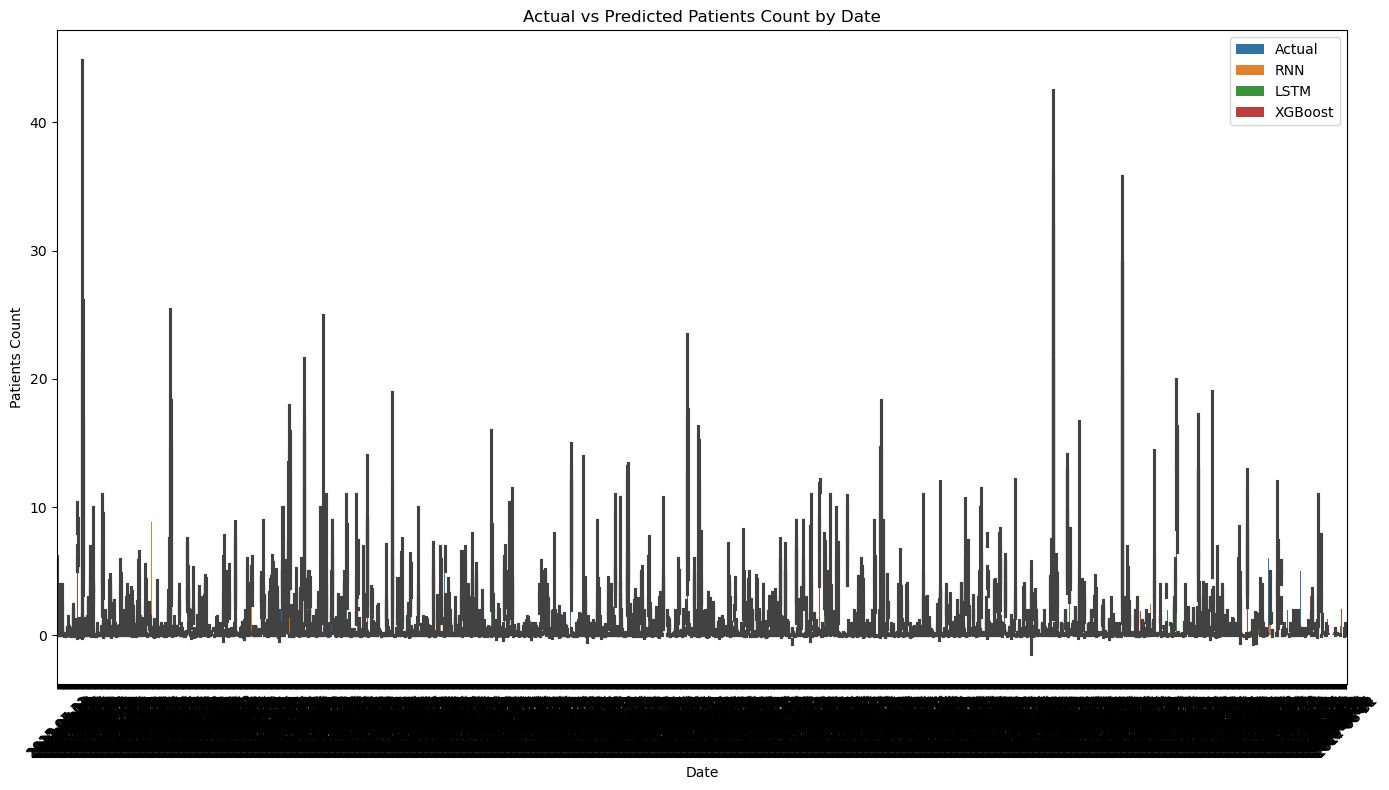

In [29]:
# Melting the dataframe for easier plotting
results_melted = results_df.melt(id_vars=['Date'], value_vars=['Actual', 'RNN', 'LSTM', 'XGBoost'],
                                 var_name='Model', value_name='Patients Count')

# 결과 시각화 (barplot)
plt.figure(figsize=(14, 8))
sns.barplot(x='Date', y='Patients Count', hue='Model', data=results_melted)
plt.title('Actual vs Predicted Patients Count by Date')
plt.xlabel('Date')
plt.ylabel('Patients Count')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()